In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score , balanced_accuracy_score, f1_score, roc_auc_score
import time

In [2]:
df = pd.read_csv('data/dataFile.csv')
df

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gyroscope,y_gyroscope,x_gyroscope,user
0,0.040027,-0.743177,-0.262221,-0.391995,0.203035,0.026631,-0.031968,3
1,0.040460,0.600845,0.465898,-1.121842,-0.556805,-0.030059,-0.312905,1
2,0.049252,1.260347,-0.319836,-0.342097,-0.110204,0.161805,-0.306240,1
3,0.049960,-0.585656,-0.278538,-0.433894,0.171001,0.088100,-0.004555,3
4,0.059245,1.274834,-0.240963,-0.358970,-0.145028,0.080974,-0.380480,1
...,...,...,...,...,...,...,...,...
232641,775.538496,-0.985645,-6.406092,5.141987,1.225872,-0.110520,1.289578,3
232642,775.539918,-7.387298,-8.144462,0.807643,-0.370583,-1.712168,-0.019191,2
232643,775.544682,0.172228,-0.416443,0.286711,-0.334846,-0.421050,-0.304001,1
232644,775.548429,-0.732786,-5.806568,5.015984,1.414098,0.109211,1.592959,3


In [3]:
from data_cleaning import remove_outliers, impute, low_pass_filter, pca

# Clean the data
df = remove_outliers(df)
df = impute(df)
df = low_pass_filter(df)
df = pca(df)

df

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gyroscope,y_gyroscope,x_gyroscope,user,z_accelerometer_lowpass,y_accelerometer_lowpass,...,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13
0,0.040027,-0.273211,-0.279689,-0.342461,0.145889,0.136416,0.005533,3,-0.087919,-0.502079,...,-0.358698,-0.992872,-1.506684,0.264751,0.385887,-0.647561,-1.242256,0.212099,0.806083,-1.118422
1,0.040460,1.260347,-0.319836,-0.342097,-0.110204,0.161805,-0.306240,1,-0.094020,-0.499130,...,-0.143218,-1.130201,-1.464593,0.341156,0.633756,-0.420294,-1.484735,0.022319,0.635951,-1.051559
2,0.049252,1.260347,-0.319836,-0.342097,-0.110204,0.161805,-0.306240,1,-0.100092,-0.496159,...,-0.135123,-1.127834,-1.465137,0.352453,0.628880,-0.427888,-1.466034,0.014356,0.629667,-1.024100
3,0.049960,-0.273211,-0.279689,-0.342461,0.145889,0.136416,0.005533,3,-0.106130,-0.493168,...,-0.334416,-0.985791,-1.508386,0.298638,0.371265,-0.670332,-1.186157,0.188215,0.787236,-1.036056
4,0.059245,1.274834,-0.240963,-0.358970,-0.145028,0.080974,-0.380480,1,-0.112131,-0.490155,...,-0.129642,-1.154960,-1.456594,0.324531,0.656941,-0.430889,-1.437520,-0.029626,0.617830,-0.974045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232641,775.538496,-0.992985,-5.758652,4.859346,1.199442,-0.058727,1.369393,3,-1.337381,0.147406,...,0.958522,2.855853,1.117234,1.361023,0.554052,-2.113465,1.122159,1.821601,-0.814296,-0.844963
232642,775.539918,-7.387298,-8.144462,0.807643,-0.370583,-1.712168,-0.019191,2,-1.338083,0.146336,...,-0.333093,2.241354,1.255150,0.144142,0.178556,-1.088618,0.677543,1.406085,-0.342954,-0.713842
232643,775.544682,0.172228,-0.416443,0.286711,-0.334846,-0.421050,-0.304001,1,-1.338672,0.145438,...,1.814419,1.222916,1.484642,0.485963,0.063601,-1.114832,0.319149,0.903399,-0.502342,-0.717991
232644,775.548429,-0.732786,-5.806568,5.015984,1.414098,0.109211,1.592959,3,-1.339158,0.144694,...,0.992154,2.918429,1.101333,1.514741,0.501382,-2.255614,1.214059,1.970074,-0.832247,-0.846098


#### Defining the target and the features the model will use 

In [4]:
target = 'user'
features = df.columns.to_list()
remove = ['user']
features = [x for x in features if x not in remove]
features

['seconds_elapsed',
 'z_accelerometer',
 'y_accelerometer',
 'x_accelerometer',
 'z_gyroscope',
 'y_gyroscope',
 'x_gyroscope',
 'z_accelerometer_lowpass',
 'y_accelerometer_lowpass',
 'x_accelerometer_lowpass',
 'z_gyroscope_lowpass',
 'y_gyroscope_lowpass',
 'x_gyroscope_lowpass',
 'pca_1',
 'pca_2',
 'pca_3',
 'pca_4',
 'pca_5',
 'pca_6',
 'pca_7',
 'pca_8',
 'pca_9',
 'pca_10',
 'pca_11',
 'pca_12',
 'pca_13']

In [5]:
# Convert time from datetime to unix, so the model can use it
df['seconds_elapsed'] = pd.to_datetime(df['seconds_elapsed']).astype('int64') // 10**9

X = df[features]
y= df[target]


# Split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
X, y, random_state=42, stratify=y, test_size=0.3)

#### Now, we build our pipeline

In [6]:
# Separate categorical and numerical columns
from sklearn.impute import SimpleImputer


categorical_cols = X.select_dtypes(exclude=['number']).columns.to_list()
numerical_cols = X.select_dtypes(include=['number']).columns.to_list()


# Pipeline for the categorical data
categorical_pipeline = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')) 
])

# Pipeline for the numeric data
numeric_pipeline = Pipeline(steps=[
    ('imp', SimpleImputer(strategy="mean")),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_pipeline, categorical_cols),
    ('numerical', numeric_pipeline ,numerical_cols)
    ], remainder='passthrough')



In [7]:
# Assemble the preprocessor and the model together using a Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
    ])



# Fit the model
pipeline.fit(X_train, y_train)


# Predict using the best model
y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)

In [8]:
# Get the performance scores
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
bcc = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
auc = roc_auc_score(y_true=y_test, y_score=y_probs, average='macro', multi_class='ovo')

print("Accuracy: ", acc)
print("Balanced Accuracy Score: ", bcc)
print("AUC Score: ", auc)

Accuracy:  0.9429463850760811
Balanced Accuracy Score:  0.9429472984425504
AUC Score:  0.9921665918324867


### Get the importance of each feature

In [9]:
# Get the trained Random Forest model
rf_model = pipeline.named_steps['model']

# Get feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get importances
importances = rf_model.feature_importances_

# Pair names and importances
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print top features
for name, score in feature_importance[:10]:
    print(f"{name}: {score:.4f}")


numerical__x_gyroscope: 0.1001
numerical__z_accelerometer: 0.0907
numerical__y_accelerometer: 0.0711
numerical__y_gyroscope: 0.0688
numerical__z_gyroscope: 0.0612
numerical__x_accelerometer: 0.0548
numerical__pca_10: 0.0395
numerical__pca_11: 0.0394
numerical__pca_4: 0.0382
numerical__pca_7: 0.0355


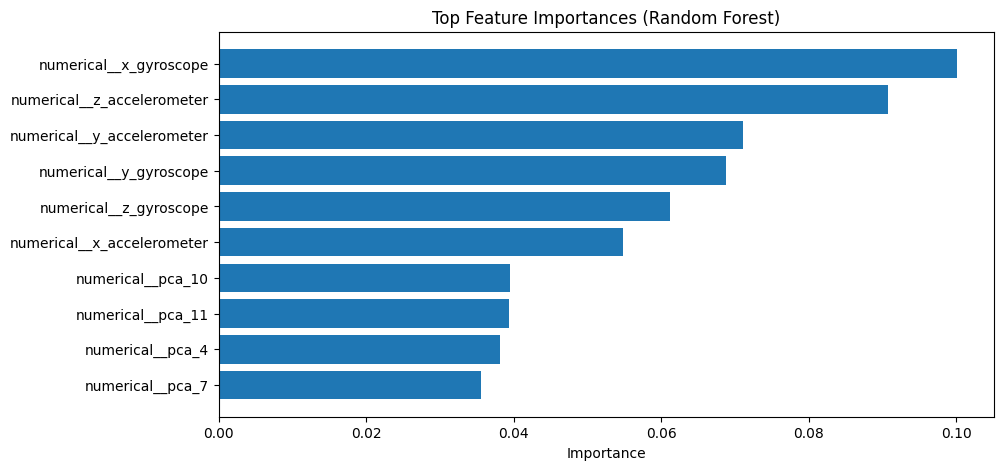

In [10]:
import matplotlib.pyplot as plt

# Show the top 10 features
top_n = 10 
names, scores = zip(*feature_importance[:top_n])

plt.figure(figsize=(10, 5))
# Reverse for descending order
plt.barh(names[::-1], scores[::-1])  
plt.xlabel("Importance")
plt.title("Top Feature Importances (Random Forest)")
plt.show()
